In [ ]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = False

In [168]:
# Catalyst
!pip install catalyst

# for augmentations
!pip install albumentations

# for pretrained segmentation models for PyTorch
#!pip install segmentation-models-pytorch==0.1.0

# for TTA
!pip install ttach

     |████████████████████████████████| 446 kB 753 kB/s eta 0:00:01
     |████████████████████████████████| 125 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 48.3 MB 1.7 MB/s eta 0:00:01    |███▌                            | 5.3 MB 911 kB/s eta 0:00:48


In [1]:
import os
import torch
import shutil
import numpy as np
import pandas as pd

from PIL import Image

In [2]:
import matplotlib.pyplot as plt

In [3]:
from typing import List

from torch.utils.data import Dataset


# Virtual kitti dataloader

In [16]:

class SingleImageVirtualKittiDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        root: str, 
        mode: str = "train", 
        transforms = None):

        assert mode in {"train", "valid", "test"}

        self.mode = mode
        self.transforms = transforms

        self.files_directory = root
  
        self.scene_folder_name = ['Scene01','Scene02','Scene06','Scene18','Scene20']
        self.scenario_folder_name = ['15-deg-left','15-deg-right','30-deg-left',
                                 '30-deg-right','clone','fog','morning',
                                 'overcast','rain','sunset']
        self.data_folder_name = ['classSegmentation','depth','rgb']
        self.file_prefix_name = ['classgt', 'depth', 'rgb']
        self.file_format_name = ['png', 'png', 'jpg']
        self.output_name = ['mask', 'depth', 'image']
        self.camera_folder_name = ['Camera_0', 'Camera_1']
        self.extrinsic_row_names = ['r1,1', 'r1,2', 'r1,3', 't1', 'r2,1', 'r2,2',
               'r2,3', 't2', 'r3,1', 'r3,2', 'r3,3', 't3', '0', '0.1', '0.2', '1']
        self.data_column_names=['scene', 'scenario', 'camera_number', 'frame_number', 'extrinsic']
        
        #Filenames extracted as a pandas dataframe
        self.filenames = self._read_split()  # read train/valid/test splits
        self.mask_colors = pd.read_csv(os.path.join(self.files_directory, 
                                               self.scene_folder_name[0], 
                                               self.scenario_folder_name[0],
                                               'colors.txt'), 
                                       delimiter=' ')
      
      
    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> dict:

        scene, scenario, camera, frame_number, x = self.filenames.iloc[idx]
        sample = {}
        for folder, prefix, file_format, output in zip(self.data_folder_name, 
                                               self.file_prefix_name,
                                               self.file_format_name,
                                               self.output_name):
            frame_name = prefix+'_'+frame_number+'.'+file_format
            image_path = os.path.join(self.files_directory, scene, scenario, 'frames', folder, camera, frame_name)
            sample[output] = np.array(Image.open(image_path))
           
        print (sample['image'].shape, sample['mask'].shape, sample['depth'].shape)

        #trimap = np.array(Image.open(mask_path))
        sample['mask'] = self._preprocess_mask(sample['mask'])

        # convert to other format HWC -> CHW
        #sample["image"] = np.moveaxis(sample["image"], -1, 0)
        #sample["mask"] = np.expand_dims(sample["mask"], 0)
        
        print (sample['image'].shape, sample['mask'].shape)
        
        #Applies transformation and converts to tensor
        if self.transforms is not None:
            #sample = self.transforms(**sample)
            
            transformed = self.transforms(image=sample['image'], 
                                          masks=[sample['mask'], sample['depth']])

            sample['image'] = transformed['image']
            sample['mask'] = transformed['masks'][0]
            sample['depth'] = transformed['masks'][1]
        
        print (sample['image'].shape, sample['mask'].shape, sample['depth'].shape)

        return sample

    def _preprocess_mask(self, mask: np.ndarray) -> np.ndarray:
        ''' 
        Convert RGB mask to single channel mask based on the color value
        provided in color.txt file 
        
        Parameters:
            mask: Numpy array mask of shape [height, width, 3]
            out: Numpy array of shape [height, width]
        '''
        preprocessed_mask = np.zeros(mask.shape[:2])
        for index, row in self.mask_colors.iterrows():
            idx = (mask == [row['r'], row['g'], row['b']])
            preprocessed_mask[idx[:,:,0]] = index

        return preprocessed_mask

    def _read_split(self):
        ''' 
        Parses the virual kitti dataset and converts to a pandas dataframe
        
        Parameters:
            out: A Pandas Dataframe
        '''
        filenames = []
        for scene in self.scene_folder_name:
            for scenario in self.scenario_folder_name:
                extrinsic = pd.read_csv(os.path.join(self.files_directory, scene, scenario,'extrinsic.txt'),
                                        delimiter=' ')
                for camera in self.camera_folder_name:
                    single_filenames = os.listdir(os.path.join(self.files_directory, 
                                                               scene, 
                                                               scenario, 
                                                               'frames', 
                                                               'rgb', 
                                                               camera))
                    single_filenames.sort()
                    for f in single_filenames:
                        #Splitting filename rgb_0000.jpg first replacing '.' with '_'
                        _, frame_number, _ = f.replace('.','_').split('_') 
                        _, camera_number = camera.split('_')
                        #Loc is a slow query 
                        x = extrinsic.loc[(extrinsic['frame'] == int(frame_number)) & \
                                          (extrinsic['cameraID'] == int(camera_number)), 
                                          self.extrinsic_row_names].values.flatten().tolist()
                        filenames.append([scene, scenario, camera, frame_number, x])

        filenames = pd.DataFrame(filenames, columns=self.data_column_names)
        

 

        if self.mode == "train":  # 90% for train
            # Creating a dataframe with 50%
            filenames = filenames.sample(frac = 0.9, random_state=55)
        elif self.mode == "valid":  # 10% for validation
            #sampling the same files with the random_state and droping them
            train_filenames = filenames.sample(frac = 0.9, random_state=55)
            filenames = filenames.drop(train_filenames.index)
            
        return filenames



## Setting up GPU 

In [5]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst
from catalyst import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.10.2, catalyst: 22.04


## Albumentation Transforms

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def pre_transforms(image_size=224):
    return [A.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      A.CoarseDropout(),
      A.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      A.GridDistortion(p=0.3),
      A.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      A.SmallestMaxSize(pre_size, p=1),
      A.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([A.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      A.LongestMaxSize(pre_size, p=1),
      A.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      A.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    #return [A.Normalize(), ToTensorV2()]
    return [ToTensorV2()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = A.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [22]:
train_transforms = compose([
    #resize_transforms(),  #There seems to be error in finding the proper crop size
    pre_transforms(),
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])



## Dataloader 

In [10]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    #dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image = dataset[idx]
        ax[i, 0].imshow(image['image'].permute(1,2,0))
        ax[i, 1].imshow(image['mask'], interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


In [17]:
%%time
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti/'

valid_dataset = SingleImageVirtualKittiDataset(root, "train", transforms=train_transforms)
#valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=int(16/2))


CPU times: user 22.9 s, sys: 36.1 ms, total: 23 s
Wall time: 23 s


In [23]:
valid_dataset.transforms = train_transforms

(375, 1242, 3) (375, 1242, 3) (375, 1242)
(375, 1242, 3) (375, 1242)
torch.Size([3, 224, 224]) torch.Size([224, 224]) torch.Size([224, 224])
(375, 1242, 3) (375, 1242, 3) (375, 1242)
(375, 1242, 3) (375, 1242)
torch.Size([3, 224, 224]) torch.Size([224, 224]) torch.Size([224, 224])
(375, 1242, 3) (375, 1242, 3) (375, 1242)
(375, 1242, 3) (375, 1242)
torch.Size([3, 224, 224]) torch.Size([224, 224]) torch.Size([224, 224])
(375, 1242, 3) (375, 1242, 3) (375, 1242)
(375, 1242, 3) (375, 1242)
torch.Size([3, 224, 224]) torch.Size([224, 224]) torch.Size([224, 224])
(375, 1242, 3) (375, 1242, 3) (375, 1242)
(375, 1242, 3) (375, 1242)
torch.Size([3, 224, 224]) torch.Size([224, 224]) torch.Size([224, 224])


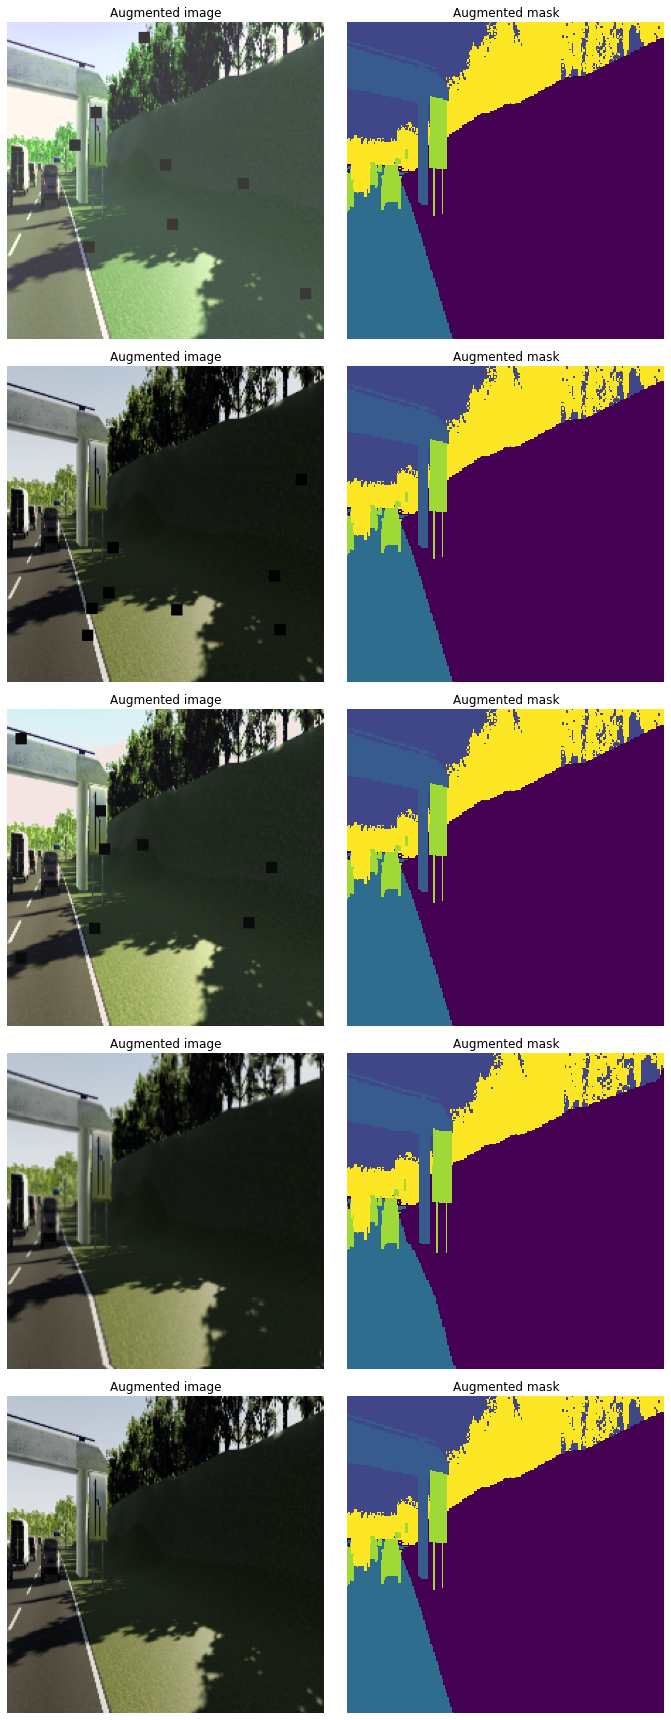

In [26]:
import random
import copy 
random.seed(2)
visualize_augmentations(valid_dataset, idx=89)



## Test code

In [119]:
files_directory = '/home/deebuls/Documents/phd/dataset/virtual_kitti'
scene_folder_name = ['Scene01','Scene02','Scene06','Scene18','Scene20']
scenario_folder_name = ['15-deg-left','15-deg-right','30-deg-left',
                         '30-deg-right','clone','fog','morning',
                         'overcast','rain','sunset']
data_folder_name = ['classSegmentation','depth','rgb']
file_prefix_name = ['classgt', 'depth', 'rgb']
file_format_name = ['png', 'png', 'jpg']
camera_folder_name = ['Camera_0', 'Camera_1']
extrinsic_row_names = ['r1,1', 'r1,2', 'r1,3', 't1', 'r2,1', 'r2,2',
       'r2,3', 't2', 'r3,1', 'r3,2', 'r3,3', 't3', '0', '0.1', '0.2', '1']

In [102]:
%%time
filenames = []
for scene in scene_folder_name:
    for scenario in scenario_folder_name:
        extrinsic = pd.read_csv(os.path.join(files_directory, scene, scenario,'extrinsic.txt'), delimiter=' ')
        for camera in camera_folder_name:
            single_filenames = os.listdir(os.path.join(files_directory, scene, scenario, 'frames', 'rgb', camera))
            single_filenames.sort()
            for f in single_filenames:
                #Splitting filename rgb_0000.jpg first replacing '.' with '_'
                _, frame_number, _ = f.replace('.','_').split('_') 
                _, camera_number = camera.split('_')
                #Loc is a slow query 
                x = extrinsic.loc[(extrinsic['frame'] == int(frame_number)) & \
                                  (extrinsic['cameraID'] == int(camera_number)), 
                                  extrinsic_row_names].values.flatten().tolist()
                filenames.append([scene, scenario, camera, frame_number, x])
                
filenames = pd.DataFrame(filenames, columns=['scene', 'scenario', 'camera_number', 'frame_number', 'extrinsic'])

CPU times: user 23.4 s, sys: 64.4 ms, total: 23.5 s
Wall time: 23.5 s


In [166]:
len(mask_colors)

15

In [167]:
mask_colors = pd.read_csv(os.path.join(files_directory, scene, scenario,'colors.txt'), delimiter=' ')
mask_colors

,Category,r,g,b
0,Terrain,210,0,200
1,Sky,90,200,255
2,Tree,0,199,0
3,Vegetation,90,240,0
4,Building,140,140,140
5,Road,100,60,100
6,GuardRail,250,100,255
7,TrafficSign,255,255,0
8,TrafficLight,200,200,0
9,Pole,255,130,0


In [273]:
def get_item(idx):
    print (filenames.iloc[0])
    scene, scenario, camera, frame_number, x = filenames.iloc[0]
    image = {}
    for folder, prefix, file_format in zip(data_folder_name, 
                                             file_prefix_name,
                                             file_format_name):
        frame_name = prefix+'_'+frame_number+'.'+file_format
        print (os.path.join(files_directory, scene, scenario, 'frames', folder, camera, frame_name))
        image_path = os.path.join(files_directory, scene, scenario, 'frames', folder, camera, frame_name)
        if (folder=='rgb'):
            #image['rgb'] = np.array(Image.open(image_path).convert("RGB"))
            image['rgb'] = np.array(Image.open(image_path))
            print ('RGB shape', image['rgb'].shape)
        else:
            image[folder] = np.array(Image.open(image_path))
            print (' shape', folder , image[folder].shape)
            
    return image
        
i = get_item(0)

scene                                                      Scene01
scenario                                               15-deg-left
camera_number                                             Camera_0
frame_number                                                 00000
extrinsic        [-0.008019686, 0.07217909, -0.9973595, 7.49445...
Name: 0, dtype: object
/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/classSegmentation/Camera_0/classgt_00000.png
 shape classSegmentation (375, 1242, 3)
/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/depth/Camera_0/depth_00000.png
 shape depth (375, 1242)
/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg
RGB shape (375, 1242, 3)


In [282]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GridDistortion(p=0.5),    
    A.RandomCrop(height=255, width=255, p=0.5),    
], p=1)

transformed = transform(image=i['rgb'], masks=[i['classSegmentation'], i['depth']])

image_transformed = transformed['image']
mask_transformed = transformed['masks'][0]
mask2_transformed = transformed['masks'][1]

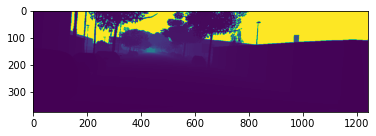

In [283]:
plt.imshow(mask2_transformed)

In [248]:
## Difeerence between differnt reads

from skimage.io import imread as gif_imread
from catalyst.contrib.utils.image import imread
 
image = imread('/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg')
mask = gif_imread('/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/classSegmentation/Camera_0/classgt_00000.png')

print (image.shape, mask.shape)

(375, 1242, 3) (375, 1242, 3)


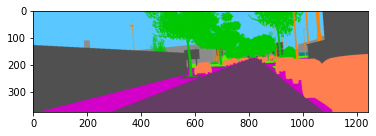

In [250]:
plt.imshow(mask)

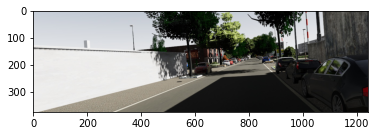

In [249]:
plt.imshow(image)

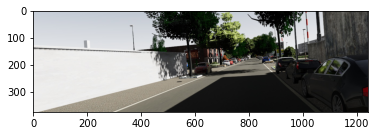

In [227]:
plt.imshow(i['rgb'])

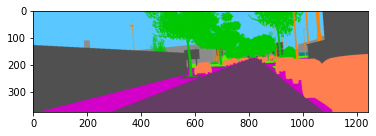

In [129]:
plt.imshow(i['classSegmentation'])

In [146]:
i['classSegmentation'].shape[:2]

(375, 1242)

In [156]:
idx = i['classSegmentation'] == [row['r'], row['g'], row['b']]
idx[:,:,0].shape

(375, 1242)

In [158]:
j = np.zeros(i['classSegmentation'].shape[:2])
for index, row in mask_colors.iterrows():
    print (index)
    idx = i['classSegmentation'] == [row['r'], row['g'], row['b']]
    j[idx[:,:,0]] = index
print (np.unique(j))

0
(30194,)
1
(92766,)
2
(62720,)
3
(92766,)
4
(9143,)
5
(80202,)
6
(0,)
7
(60978,)
8
(0,)
9
(60978,)
10
(129745,)
11
(2,)
12
(60978,)
13
(62720,)
14
(62720,)
[ 0.  3.  4.  5. 10. 11. 12. 14.]


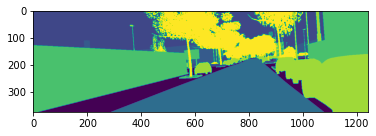

In [159]:
plt.imshow(j)

In [ ]:
def rgb_to_mask(img, id2code):
    posterior = map(self.single_row_calculation, 
                    prior, 
                    current)

In [ ]:

def rgb_to_mask(img, id2code):
    ''' 
        Converts a RGB image mask of shape [batch_size,h, w, color_code], to a mask of shape
        [batch_size,n_classes,h,w]
        
        Parameters:
            img: A RGB img mask
            color_map: Dictionary representing color mappings: ecah class assigns to a unique color code
        returns:
            out: A Binary Mask of shape [batch_size, classes, h, w]
    '''
    
    # num_classes is equal to len(mask) 
    num_classes = len(id2code)
    
    # it makes a tensor of shape h,w,num_classes:(720,960,num_classes)
    shape = img.shape[:2]+(num_classes,)
    
    # it makes a tensor with given shape and with type float64
    out = np.zeros(shape, dtype=np.float64)
    
    # 
    for i, cls in enumerate(id2code):
        
        #print(f'i: {i}, cls: {cls}')
        
        # img.reshape((-1,3)) flats mask except in channels
        
        # it reads thecolor code for a multiplication of higght and width and if it is one of the color code of 
        # the classes that we have then the third dimension takes the label of that class and the first
        # two dimsnions return to the hight and width  
        out[:,:,i] = np.all(np.array(img).reshape((-1,3)) == id2code[i], axis=1).reshape(shape[:2])
        
        # out: hight, width, class
        # returns class, hight, width
    return(out.transpose(2,0,1))